# VAE Tutorial

- Implementation of VAE from :
    - https://arxiv.org/abs/1312.6114
- Reference codes :
    - https://github.com/Jackson-Kang/Pytorch-VAE-tutorial

## What do we need?

- Dataset : MNIST
- Encoder 
- Decoder
- Sampler with reparameterization trick
- Loss function

In [2]:
import torch
import torch.nn as nn
import numpy as np

## Model Hyperparameters

- Device : CPU / GPU?
- Batch size
- learning rate / Epoch
- Vector Dimensions ?
    - input dim
    - hidden dim
    - latent dim(output of encoder)

In [3]:
dataset_path = '~/datasets'
Device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

batch_size = 100
x_dim = 784
hidden_dim = 400
latent_dim = 200

lr = 1e-3
epochs = 30

## Data Preparation

### Properties of MNIST

- Basically `PIL.Image` type or np
- Should convert to `torch.Tensor` type 
    - Use `transforms.ToTensor()` !
    - pixel values converted : (0 ~ 255) $\rightarrow$ (0 ~ 1)

---

+) How to Normalize the pixel values? 

- Use `transforms.Normalize(mean, std, inplace = True)`
    - Requires Tuple arguements
- MNIST Statistics
    - mean : 0.1307
    - std : 0.3081

In [4]:
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

mnist_transform = transforms.Compose([transforms.ToTensor(), ])

# additional arguments for DataLoader
# num_workers : number of CPU working process while loading data, 1 -> main + 1 more process
# pin_memory : load the batch on pinned memory : Faster CPU -> GPU data transfer 
kwargs = {'num_workers' : 1, 'pin_memory' : True}

train_dataset = MNIST(dataset_path, transform = mnist_transform, train = True, download = True)
test_dataset = MNIST(dataset_path, transform = mnist_transform, train = False, download = True)

# DataLoader Setting
train_loader = DataLoader(dataset = train_dataset, batch_size=batch_size, shuffle = True, **kwargs)
test_loader = DataLoader(dataset = test_dataset, batch_size=batch_size, shuffle = False, **kwargs)

## Constructing Encoder-Decoder Structure

### Encoder : Gaussian MLP

- $q_{\phi}(\mathbf z \vert \mathbf x) = \mathcal N(\mathbf z ; \mathbf u^{(i)}, \bm \sigma^{2(i)}\bm I)$
- $\mathbf x \in \mathbb R^{784} \rightarrow \mathbf u, \bm \sigma \in \mathbb R^{latent}$
- Two hidden layer MLP
    - input - hidden1 - hidden2 - mean / var

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_mean = nn.Linear(hidden_dim, latent_dim)
        self.fc_var = nn.Linear(hidden_dim, latent_dim)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)

        out = self.fc2(out)
        out = self.relu(out)

        mean = self.fc_mean(out)
        # encoder actually returns log_var, not the actual var or std
        log_var = self.fc_var(out)

        return mean, log_var

### Decoder : Multivariate Bernoulli MLP

- MNIST Pixel : Value of 0 ~ 1 (after applying `ToTensor()`)
    - Consider only 0 and 1 for each pixel
    - Then we can use Berloulli Distribution for each pixel values
    - Actual input and generated vectors : values of 0 ~ 1, Not 0/1
    - Strictly, Not Bernoulli, but consider $\mathbf x$ as soft target

- $p_{\theta}(\mathbf x | \mathbf z) = \prod_{d=1}^{D}\mathrm{Bernoulli}(x_d; p_d(\mathbf z))$
    - $p_d$ : Precidicted Probability of d-th pixel 
    - $p_d(\mathbf z)$ should be the range of (0, 1) $\rightarrow$ Use Sigmoid !
- $\mathbf z \in \mathbb R^{latent} \rightarrow \mathbf x \in \mathbb R^{784}$
- Symmetrical Structure to Encdoer

In [12]:
class Decoder(nn.Module):
    
    def __init__(self, output_dim, hidden_dim, latent_dim):
        super(Decoder, self).__init__()
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.fc1 = nn.Linear(latent_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.logit = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, z):
        out = self.fc1(z)
        out = self.relu(out)

        out = self.fc2(out)
        out = self.relu(out)
        
        out = self.logit(out)
        out = self.sigmoid(out)

        return out

### Model with Sampler : Latent Vector Sampling 

- Sample $\mathbf z$ from $\mathcal N(\mathbf z ; \mathbf u^{(i)}, \bm \sigma^{2(i)}\bm I)$
- Implement Reparameterization Trick !
    - $\mathbf z^{(i, l)} = \boldsymbol \mu^{(i)}+\boldsymbol \sigma^{(i)} \ \odot \ \boldsymbol \epsilon^{(l)} \quad \mathrm{and} \quad \boldsymbol \epsilon^{(l)} \sim \mathcal N(0, \boldsymbol I)$
    - Usually, $l=1$ when using mini-batch SGD
    - $i$ : index of each data in batch

In [13]:
# Defining the Whole Model
class VAE(nn.Module):

    def __init__(self, Encoder, Decoder):
        super(VAE, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder
    
    # Sampling and reperameterization
    def sampler(self, mean, std):
        eps = torch.rand_like(std).to(Device)
        z = mean + std * eps # element-wise operation automatically done
        return z
    
    def forward(self, x):
        mean, log_var = self.Encoder(x)
        z = self.sampler(mean, torch.exp(0.5*log_var))
        x_hat = self.Decoder(z)

        return x_hat, mean, log_var

In [14]:
import torch.optim as optim

# Define Model Class
encoder = Encoder(x_dim, hidden_dim, latent_dim)
decoder = Decoder(x_dim, hidden_dim, latent_dim)
model = VAE(encoder, decoder).to(Device)

optimizer = optim.Adam(model.parameters(), lr = lr)
# But how to impelement criterion ?
# PyTorch does not offer fully made criterion for VAE architecture... 

## Loss Function Design

### Following is the Generic form of SGVB :

- $\tilde{\mathcal L}^{B}(\boldsymbol{\theta, \phi};\mathbf x^{(i)}) = -D_{KL}(q_{\phi}(\mathbf z|\mathbf x^{(i)})\Vert p_{\theta}(\mathbf z)) + \frac{1}{L}\sum_{l=1}^{L}\left(\log p_{\theta}(\mathbf x^{(i)}| \mathbf z^{(i, l)})\right)$
    - $\mathrm{where} \quad \mathbf z^{(i,l)} = g_{\phi}(\epsilon^{(i, l)}, \mathbf x^{(i)}) \quad \mathrm{and} \quad \boldsymbol \epsilon^{(l)} \sim p(\boldsymbol \epsilon)$
    - Consider $L = 1$ since we use mini-batch SGD
- For mini batch ... :
    - $\mathcal L(\boldsymbol{\theta, \phi};\boldsymbol X) \simeq \tilde{\mathcal L}^{M}(\boldsymbol{\theta, \phi};\boldsymbol X^M) = N\times\frac{1}{M}\sum_{i=1}^{M} \tilde{\mathcal L}(\boldsymbol{\theta, \phi};\mathbf x^{(i)})$ 
- $-D_{KL}(q_{\phi}(\mathbf z|\mathbf x^{(i)})\Vert p_{\theta}(\mathbf z)) + \left(\log p_{\theta}(\mathbf x^{(i)}| \mathbf z^{(i)})\right)$
    - Prior Matching Term
    - Reconstruction Error Term

---

### Solving Prior Matching Term(Gaussian Case)

Check the __Appendix B__ of the paper

$-D_{KL}(q_{\phi}(\mathbf z|\mathbf x^{(i)})\Vert p_{\theta}(\mathbf z)) = \frac{1}{2}\sum_{j=1}^{J}\left(1+\log((\sigma_j^{(i)})^2)-(\mu_j^{(i)})^2 - (\sigma_j^{(i)})^2\right)$

- $j$ : index of the element of $\mathbf u, \bm \sigma$ $\rightarrow$ `latent_dim`
- $i$ : index of the datapoint in batch
- Use `torch.sum` for $\sum_{j=1}^{J}$ !

---

### Solving Reconstruction Error Term

$\log p_{\theta}(\mathbf x^{(i)}| \mathbf z^{(i)})$

- Decoder $\rightarrow$ Assuming Multivariate Bernoulli
- Theoretically, training undergoes __MLE__ process
    - we usually use log-likelihood for evaluation

$\log p_{\theta}(\mathbf x \vert \mathbf z) = \displaystyle \log\prod_{d=1}^{D}p_d^{x_d}(1-p_d)^{1-x_d} = \sum_{d=1}^{D}\log\left(p_d^{x_d}(1-p_d)^{1-x_d}\right)$\
$\quad \quad \quad \quad \ \ \ = \displaystyle \sum_{d=1}^{D}[x_d\log p_d + (1-x_d)\log(1-p_d)] \rightarrow$  __`BCE` is equal to negative log-likelihood__

- Use `nn.functional.binary_cross_entropy(x, x_hat, reduction = 'sum')` to Impelemt BCE for a vector!
- `Reduction = 'sum'` : Add up all elementwise BCE results

---

### Actual Loss

- SGVB $\rightarrow$ $\max \mathcal L$
- We usually minimize the loss, so change to : $\min (-\mathcal L)$
- $\max(-D_{KL} + \text{LL}) = \min(D_{KL} + BCE)$

It's actually easy to implement ; \
$\displaystyle \frac{1}{2}\sum_{j=1}^{J}\left(1+\log((\sigma_j^{(i)})^2)-(\mu_j^{(i)})^2 - (\sigma_j^{(i)})^2\right) + \sum_{d=1}^{D}[x_d\log p_d + (1-x_d)\log(1-p_d)]$

In [15]:
def VAEloss(x, x_hat, mean, log_var):
    D_KL = -0.5 * torch.sum(1 + log_var - mean.pow(2) - torch.exp(log_var))
    # ! Caveat ! : BCE is NOT SYMMETRIC ... Value May Explode !!! 
    BCE = nn.functional.binary_cross_entropy(x_hat, x, reduction = 'sum')
    overall_loss = D_KL + BCE

    return overall_loss# Returns Tensor type

## Training Process

In [ ]:
model.train()

for epoch in range(epochs):
    total_loss = 0
    for i, (x, _) in enumerate(train_loader):
        # stretch the matrix(28*28) to vector(784)
        x = torch.flatten(x, start_dim = 1)
        x = x.to(Device)

        # Evaluate latent space parameters
        x_hat, mean, log_var = model(x)
        # Evaluate the loss
        loss = VAEloss(x, x_hat, mean, log_var)
        total_loss += loss.item()

        # Actual Parameter Update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print("Epoch : ", epoch + 1, " Average Loss : ", total_loss/(i*batch_size))

Epoch :  1  Average Loss :  169.76361738965986
Epoch :  2  Average Loss :  124.43218384808013
Epoch :  3  Average Loss :  113.63074491013668
Epoch :  4  Average Loss :  105.81775335194074
Epoch :  5  Average Loss :  100.64437649989566
Epoch :  6  Average Loss :  97.290597838846
Epoch :  7  Average Loss :  94.94744698194908
Epoch :  8  Average Loss :  92.89684888225167
Epoch :  9  Average Loss :  91.10983836993948
Epoch :  10  Average Loss :  89.79143862818239
Epoch :  11  Average Loss :  88.72420642477046
Epoch :  12  Average Loss :  87.81685811802222
Epoch :  13  Average Loss :  86.97452616339733
Epoch :  14  Average Loss :  86.34318256664754
Epoch :  15  Average Loss :  85.75770762957794
Epoch :  16  Average Loss :  85.25897727495044
Epoch :  17  Average Loss :  84.76347201390338
Epoch :  18  Average Loss :  84.34361505830029
Epoch :  19  Average Loss :  83.88112809271963
Epoch :  20  Average Loss :  83.62286349645242
Epoch :  21  Average Loss :  83.18205944640808
Epoch :  22  Averag

## Reconstruction and Generation

- Reconstruction using test dataset
- Generation using the sampled latent vector

In [17]:
import matplotlib.pyplot as plt

model.eval()

with torch.no_grad():
    for i, (x, _) in enumerate(test_loader):
        x = torch.flatten(x, start_dim=1)
        x = x.to(Device)
        x_hat, _, _ = model(x)

        break

In [18]:
def show_image(x, idx, ax):
    x = x.view(batch_size, 28, 28)
    ax.imshow(x[idx].detach().cpu().numpy())

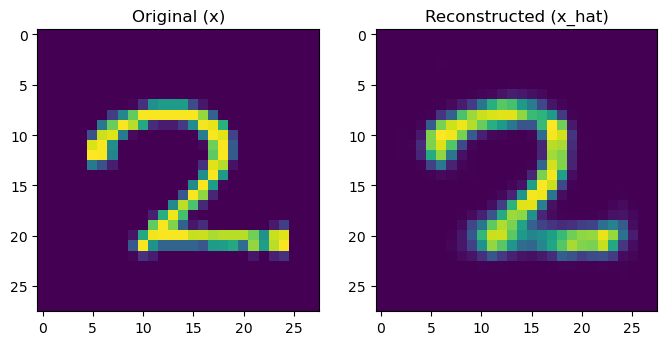

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

show_image(x, 77, ax=axes[0])
axes[0].set_title("Original (x)")

show_image(x_hat, 77, ax=axes[1])
axes[1].set_title("Reconstructed (x_hat)")

plt.show()

Reconstruction seems fine... How about the actual generation process?

### Probability map version Generation

In [20]:
with torch.no_grad():
    noise = torch.randn(batch_size, latent_dim).to(Device)
    probs = decoder(noise)

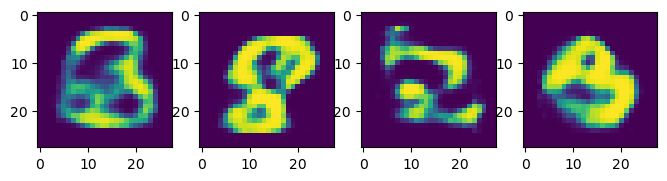

In [21]:
fig, axes = plt.subplots(1, 4, figsize=(8, 4))

show_image(probs, 0, ax=axes[0])
show_image(probs, 1, ax=axes[1])
show_image(probs, 2, ax=axes[2])
show_image(probs, 3, ax=axes[3])

plt.show()

### Binary Version

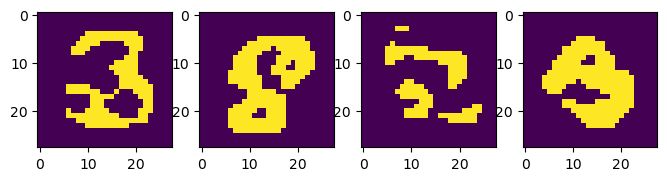

In [22]:
binary_images = (probs >= 0.5).float()

fig, axes = plt.subplots(1, 4, figsize=(8, 4))

show_image(binary_images, 0, ax=axes[0])
show_image(binary_images, 1, ax=axes[1])
show_image(binary_images, 2, ax=axes[2])
show_image(binary_images, 3, ax=axes[3])

plt.show()

### Sampling Version (Actual Generation Process)

Each values of $\hat{\mathbf x}$ works as a parameter for univariate Bernoulli distribution, whose PDF is :\
$p^x(1-p)^{1-x} \quad \mathrm{where} \quad x = 0 \ \mathrm{or} \ 1$

Sample the values for each pixel using the PDF above.

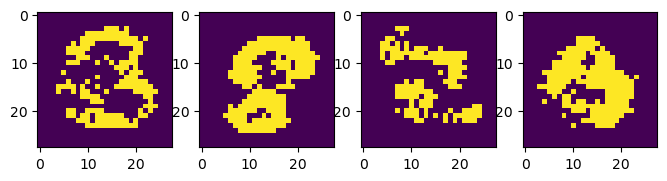

In [23]:
sampling_images = torch.bernoulli(probs)

fig, axes = plt.subplots(1, 4, figsize=(8, 4))

show_image(sampling_images, 0, ax=axes[0])
show_image(sampling_images, 1, ax=axes[1])
show_image(sampling_images, 2, ax=axes[2])
show_image(sampling_images, 3, ax=axes[3])

plt.show()

`Epoch :  30  Average Loss :  81.22162880517007`

High loss, which means encoder $q_{\phi}(\mathbf z \vert \mathbf x)$ is still quite different from Gaussian.\
This seems to be the main reason for low-quality generation

In [5]:
import os

print("cwd:", os.getcwd())
print("dataset_path raw:", dataset_path)
print("dataset_path expanded:", os.path.expanduser(dataset_path))

print("train_dataset.root:", train_dataset.root)
print("exists root?:", os.path.exists(train_dataset.root))
print("contents:", os.listdir(train_dataset.root))

cwd: c:\Users\evana\OneDrive\Desktop\projects\deep-learning-practice\yebin\Tutorials
dataset_path raw: ~/datasets
dataset_path expanded: C:\Users\evana/datasets
train_dataset.root: C:\Users\evana/datasets
exists root?: True
contents: ['MNIST']
